# Mohr circle and stress paths

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/mohr_circles_and_stress_paths.ipynb).



## Required modules and global setup for plots

In [1]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, widgets, fixed
from IPython import get_ipython
from IPython.display import display, clear_output

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    %pip install ipympl &> ~/pip-log.txt
    from google.colab import output
    output.enable_custom_widget_manager()

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

# Funciones

In [2]:
def plot_mohr_circle(
    sigma_xx, sigma_yy, tau_xy, plot_envelope=True, envelope={'c': 5, 'ϕ': 27},
    plot_pole=False, plot_plane=False, alpha=0, xlim=None, ylim=None
):
    if type(envelope) == str:  # This is for interpreting in from the widget
        envelope = ast.literal_eval('{' + envelope + '}')

    c = 0.5 * (sigma_xx + sigma_yy)
    r = np.sqrt((sigma_xx - c) ** 2 + tau_xy**2)
    sig_1 = r * np.cos(0) + c
    sig_3 = r * np.cos(np.pi) + c

    outcome = {
        "sig_1": sig_1,
        "sig_3": sig_3,
        "sig_xx": sigma_xx,
        "sig_yy": sigma_yy,
        "tau_xy": tau_xy,
        "s": 0.5 * (sig_1 + sig_3),
        "t": 0.5 * (sig_1 - sig_3),
        "p": 1 / 3 * (sig_1 + 2 * sig_3),
        "q": sig_1 - sig_3,
    }

    theta = np.linspace(0, 2 * np.pi, 200)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[7, 4.5])
    ax.axhline(y=0, c="k")
    ax.plot(r * np.cos(theta) + c, r * np.sin(theta), c="k")  # Mohr circle

    label = "$\sigma_{1}=$" + f"{sig_1:.1f}"  # sigma_1
    ax.plot(sig_1, 0, ls="", c="#BB5566", marker=".", ms=12, label=label)
    label = "$\sigma_{3}=$" + f"{sig_3:.1f}"  # sigma_3
    ax.plot(sig_3, 0, ls="", c="#004488", marker=".", ms=12, label=label)
    # Mean stress
    ax.plot(c, 0, ls="", c="k", marker="o", label="$\sigma_\mathrm{m}=$" + f"{c:.1f}")
    label = "$\\tau_\mathrm{max}=$" + f"{r:.1f}"  # tau_max
    ax.plot(c, r, ls="", c="orchid", marker="o", ms=7, label=label)
    # sigma_xx, tau_xy
    label = ("$\sigma_{xx}=$" + f"{sigma_xx:.1f}" + ",\n$\\tau_{xy}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_xx, tau_xy, ls="", c="#DDAA33", marker="s", label=label)
    # sigma_yy, (-)tau_xy
    label = ("$\sigma_{yy}=$" + f"{sigma_yy:.1f}" + ",\n$\\tau_{yx}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_yy, -1 * tau_xy, ls="", c="#117733", marker="s", label=label)

    pole = (sigma_xx, -1 * tau_xy)
    if plot_pole:  # Pole and stress on a plane
        ax.axhline(y=pole[1], c="k", ls="--", lw=0.75)
        ax.axvline(x=pole[0], c="k", ls="--", lw=0.75)
        ax.plot(*pole, ls="", c="k", marker="o", fillstyle='none', label=f"Pole: {pole}")
    if  plot_plane:
        beta = 0.5 * np.degrees(np.arctan2(2 * tau_xy, sigma_xx - sigma_yy))
        theta = alpha + beta
        plane_sig_n = r * np.cos(np.radians(2 * theta)) + c
        plane_tau_n = r * np.sin(np.radians(2 * theta))
        label = (
            "Stress state on the plane\n" + "$\sigma_\mathrm{n}=$" + f"{plane_sig_n:.1f}"
            + ", $\\tau_\mathrm{n}=$" + f"{plane_tau_n:.1f}"
        )
        ax.plot(plane_sig_n, plane_tau_n, ls="", c="r", marker=".", label=label)
        ax.plot(
            (plane_sig_n, pole[0]), (plane_tau_n, pole[1]), c="r", ls="--",
            lw=0.75, label=f"Plane at {alpha:.1f}" + "$^{\circ}\circlearrowleft$ from $y^{(+)}$"
        )
        ax.plot(
            (plane_sig_n, c), (plane_tau_n, 0), c="b", ls="--",
            lw=0.75, label="2$\\theta=$" + f"{theta:.1f}" + "$^{\circ}$"
        )

    if plot_envelope:  # Failure envelope
        tan_ϕ = np.tan(np.radians(envelope['ϕ']))
        c_env = envelope['c']
        label = ("Failure criterion \n $\\tau_\mathrm{n} = "+ f"{c_env} + "
                 + "\\tan" + f"{envelope['ϕ']}^\circ" + "\sigma_\mathrm{n}$")
        xlim = ax.get_xlim() if xlim is None else xlim
        ylim = ax.get_ylim() if ylim is None else ylim
        x_env = np.array([-9e9, 9e9])
        ax.plot(x_env, tan_ϕ * x_env + c_env, c="r", label=label)

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(True, ls="--")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.set_aspect("equal", anchor=None)
    ax.set(
        xlabel="Normal stress, $\sigma_\mathrm{n}$",
        ylabel="Shear stress, $\\tau_\mathrm{n}$",
        xlim=xlim,
        ylim=ylim
    )
    # fig.tight_layout()
    plt.show()
    return outcome

In [3]:
def plot_all_mohr_circles(stages, envelope={'c': 20, 'ϕ': 35}, xlim=None, ylim=None):
    theta = np.linspace(0, 2 * np.pi, 200)
    # sigma = np.linspace(0, sig_1 * factor, 200)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6.5, 3.0])
    for i, st in enumerate(stages):
        sigma_xx, sigma_yy, tau_xy = st['sig_xx'], st['sig_yy'], st['tau_xy']
        c = 0.5 * (sigma_xx + sigma_yy)
        r = np.sqrt((sigma_xx - c) ** 2 + tau_xy**2)
        sig_1 = r * np.cos(0) + c
        sig_3 = r * np.cos(np.pi) + c
        # ax.axhline(y=0, xmin=0, xmax=sig_1 * factor, c="k")
        ax.plot(r * np.cos(theta) + c, r * np.sin(theta), label=f'Stage {i}')  # Mohr circle
    # Failure envelope
    tan_ϕ = np.tan(np.radians(envelope['ϕ']))
    c_env = envelope['c']
    label = ("Failure criterion \n $\\tau_\mathrm{n} = "+ f"{c_env} + "
                + "\\tan" + f"{envelope['ϕ']}^\circ" + "\sigma_\mathrm{n}$")
    xlim = ax.get_xlim() if xlim is None else xlim
    ylim = ax.get_ylim() if ylim is None else ylim
    x_env = np.array([-9e9, 9e9])
    ax.plot(x_env, tan_ϕ * x_env + c_env, c="r", label=label)

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(True, ls="--")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    # ax.axis("equal")
    ax.set_aspect("equal", adjustable=None, anchor='C')
    ax.set(
        xlabel="Normal stress, $\sigma_\mathrm{n}$",
        ylabel="Shear stress, $\\tau_\mathrm{n}$",
        xlim=xlim,
        ylim=ylim)
    # fig.tight_layout()
    plt.show()
    return

In [4]:
def plot_stress_path(stages, envelope={"c": 10, "ϕ": 30}):
    # Mohr-Coulomb envelope
    phi_r = np.radians(envelope["ϕ"])
    c = envelope["c"]
    𝜎1, 𝜎3, s, t, p, q = [], [], [], [], [], []
    for st in stages:
        𝜎1.append(st["sig_1"])
        𝜎3.append(st["sig_3"])
        s.append(st["s"])
        t.append(st["t"])
        p.append(st["p"])
        q.append(st["q"])

    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=[11, 4.0])
    quiver = lambda x, y: (
        0.5 * (x[1:] + x[:-1]),
        0.5 * (y[1:] + y[:-1]),
        np.diff(x)/np.sqrt(np.diff(x)**2+np.diff(y)**2),
        np.diff(y)/np.sqrt(np.diff(x)**2+np.diff(y)**2),
    )

    x_env = np.array([-9e9, 9e9])
    # sigma_1, sigma_3
    𝜎1, 𝜎3 = np.array(𝜎1), np.array(𝜎3)
    ax0.plot(𝜎3, 𝜎1, ls="--", c="k", marker="o", mfc="tomato", lw=0.75)
    ax0.quiver(*quiver(𝜎3, 𝜎1), pivot="mid", angles="xy")
    label = (
        "Failure criterion: \n$\sigma_1' =  "
        + "\\frac{2c' \cos \phi'}{1 - \sin \phi'} + "
        + "\sigma_3' \\frac{1 + \sin \phi'}{1 - \sin \phi'} $"
    )
    𝜎1_𝜎3_int = 2 * c * np.cos(phi_r) / (1 - np.sin(phi_r))
    𝜎1_𝜎3_slope = (1 + np.sin(phi_r)) / (1 - np.sin(phi_r))
    xlim = ax0.get_xlim()
    ylim = ax0.get_ylim()
    ax0.plot(x_env, 𝜎1_𝜎3_slope * x_env + 𝜎1_𝜎3_int, c="#BB5566", label=label)
    ax0.set(xlabel="$\sigma_{3}'$", ylabel="$\sigma_{1}'$")
    ax0.set_xlim((0, 1.2 * xlim[1]))
    ax0.set_ylim((0, 1.2 * ylim[1]))

    # s, t
    s, t = np.array(s), np.array(t)
    ax1.plot(s, t, ls="--", c="k", marker="o", mfc="tomato", lw=0.75)
    ax1.quiver(*quiver(s, t), pivot="mid", angles="xy")
    label = "Failure criterion: \n$t = c' \cos \phi' + s'\,\sin \phi' $"
    s_t_int = c * np.cos(phi_r)
    s_t_slope = np.sin(phi_r)
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    ax1.plot(x_env, s_t_slope * x_env + s_t_int, c="#004488", label=label)
    ax1.set(xlabel="$s'$", ylabel="$t$")
    ax1.set_xlim((0, 1.2 * xlim[1]))
    ax1.set_ylim((0, 1.2 * ylim[1]))

    # p, q
    p, q = np.array(p), np.array(q)
    ax2.plot(p, q, ls="--", c="k", marker="o", mfc="tomato", lw=0.75)
    ax2.quiver(*quiver(p, q), pivot="mid", angles="xy")
    label = (
        "Failure criterion: \n$q =  "
        + "\\frac{6\cos \phi'}{3 - \sin \phi'} +"
        + "\\frac{6\sin \phi'}{3 - \sin \phi'} p'$"
    )
    p_q_int = c * 6 * np.cos(phi_r) / (3 - np.sin(phi_r))
    p_q_slope = 6 * np.sin(np.arctan(phi_r)) / (3 - np.sin(np.arctan(phi_r)))
    xlim = ax2.get_xlim()
    ylim = ax2.get_ylim()
    ax2.plot(x_env, p_q_slope * x_env + p_q_int, c="#DDAA33", label=label)
    ax2.set(xlabel="$p'$", ylabel="$q$")
    ax2.set_xlim((0, 1.2 * xlim[1]))
    ax2.set_ylim((0, 1.2 * ylim[1]))

    for ax in (ax0, ax1, ax2):
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))
        ax.grid(True, ls=":")
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
    # fig.tight_layout()
    plt.show()
    return


# Herramienta No. 1

Estado de esfuerzos en la misma etapa para diferentes puntos.

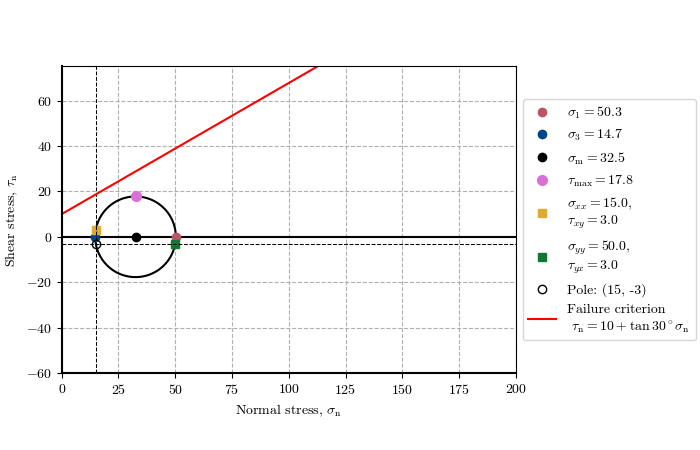

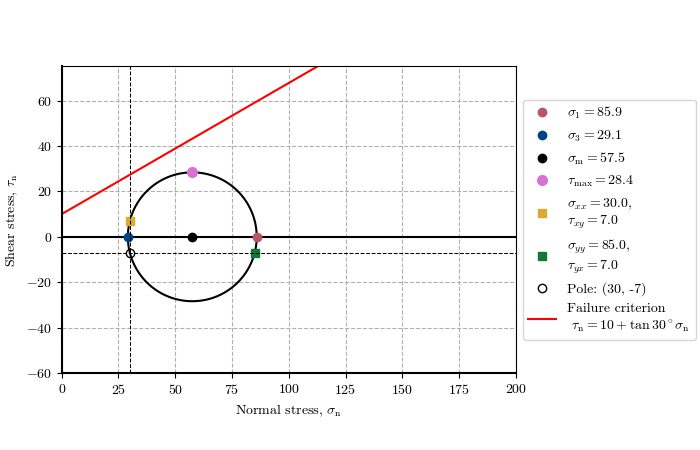

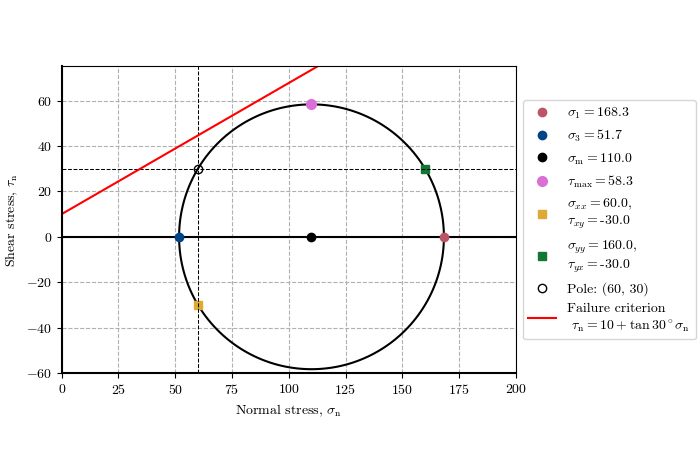

In [5]:
slope1_ptX_stage3 = plot_mohr_circle(
    sigma_xx=15, sigma_yy=50, tau_xy=3, envelope={'c': 10, 'ϕ': 30}, xlim=(00, 200), ylim=(-60, 75), plot_pole=True)
slope1_ptY_stage3 = plot_mohr_circle(
    sigma_xx=30, sigma_yy=85, tau_xy=7, envelope={'c': 10, 'ϕ': 30}, xlim=(00, 200), ylim=(-60, 75), plot_pole=True)
slope1_ptZ_stage3 = plot_mohr_circle(
    sigma_xx=60, sigma_yy=160, tau_xy=-30, envelope={'c': 10, 'ϕ': 30}, xlim=(00, 200), ylim=(-60, 75), plot_pole=True)

# Herramienta No. 2

Estado de esfuerzos en el mismo punto para diferentes etapas.

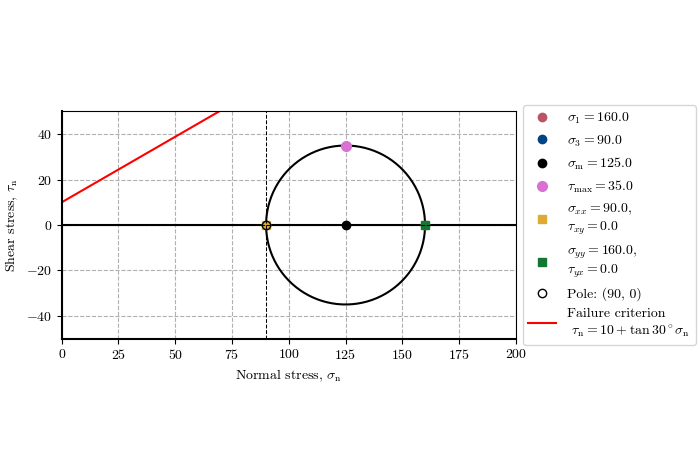

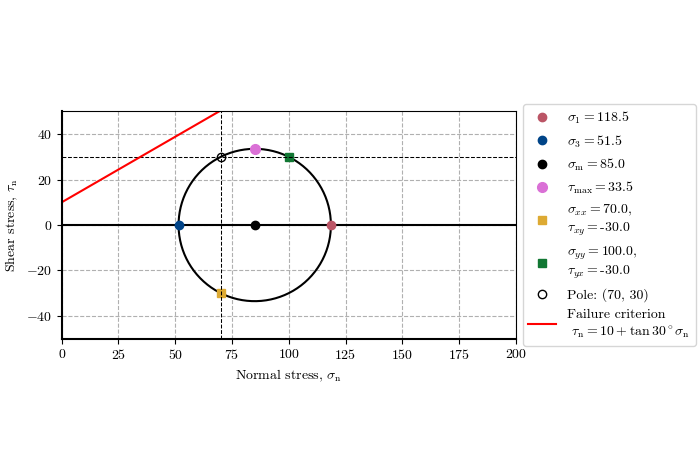

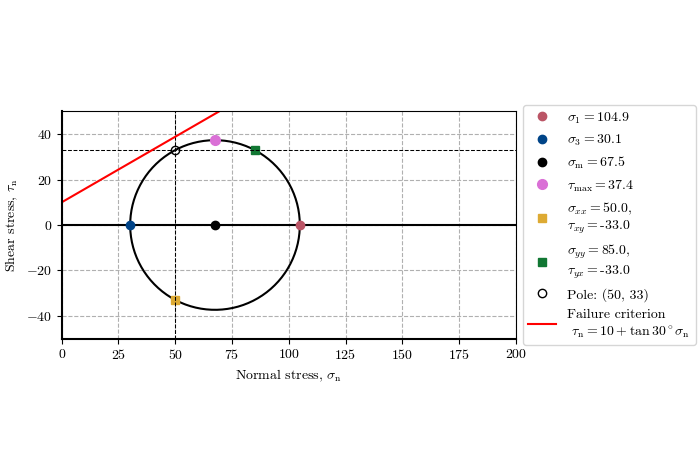

In [6]:
slope1_ptX_stage1 = plot_mohr_circle(sigma_xx=90, sigma_yy=160, tau_xy=0, envelope={'c': 10, 'ϕ': 30}, xlim=(0, 200), ylim=(-50, 50), plot_pole=True)
slope1_ptX_stage2 = plot_mohr_circle(sigma_xx=70, sigma_yy=100, tau_xy=-30, envelope={'c': 10, 'ϕ': 30}, xlim=(0, 200), ylim=(-50, 50), plot_pole=True)
slope1_ptX_stage3 = plot_mohr_circle(sigma_xx=50, sigma_yy=85, tau_xy=-33, envelope={'c': 10, 'ϕ': 30}, xlim=(0, 200), ylim=(-50, 50), plot_pole=True)

# Herramienta No. 3
Trayectorias de tensiones

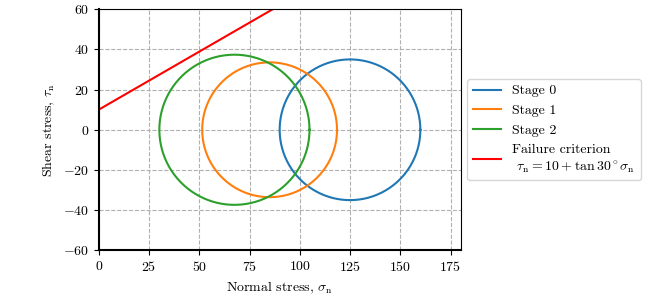

In [7]:
stages = (slope1_ptX_stage1, slope1_ptX_stage2, slope1_ptX_stage3)
plot_all_mohr_circles(stages, envelope={'c': 10, 'ϕ': 30}, xlim=(0, 180), ylim=(-60, 60))

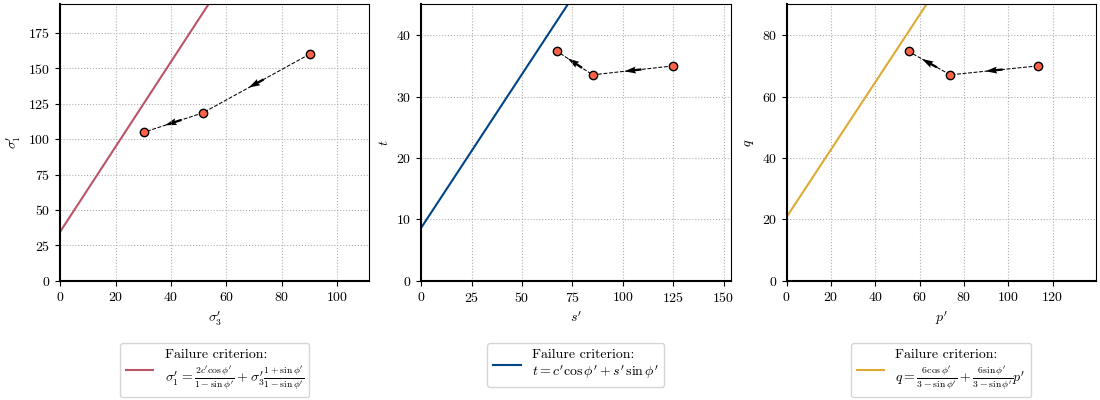

In [8]:
stages = (slope1_ptX_stage1, slope1_ptX_stage2, slope1_ptX_stage3)
plot_stress_path(stages, envelope={'c': 10, 'ϕ': 30})

# Setup for html output

In [9]:
%%html
<style> div.jupyter-widgets.widget-label {display: none;} </style>